In [2]:
import ctypes
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#from data_charge import load_images_from_mongodb
#from prepar_data import preprocess_for_rust, transform
import matplotlib.pyplot as plt
import math
from PIL import Image


In [3]:
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import numpy as np

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

def preprocess_for_rust(images, labels):
    X = np.stack([transform(img).numpy().flatten() for img in images])
    X = X.astype(np.float64)

    le = LabelEncoder()
    y_int = le.fit_transform(labels)

    lb = LabelBinarizer()
    y_onehot = lb.fit_transform(y_int)
    if y_onehot.shape[1] == 1:  # pour les cas binaire
        y_onehot = np.hstack([1 - y_onehot, y_onehot])

    y_onehot = y_onehot.astype(np.float64)

    return X, y_onehot, le


In [4]:
# Charger la bibliothèque Rust
lib = ctypes.CDLL("target/release/mymodel.dll")

# === Définir les types pour le Deep MLP ===

lib.create_deep_mlp_classifier.argtypes = [
    ctypes.c_size_t,   # n_inputs
    ctypes.c_size_t,   # hidden_units
    ctypes.c_size_t,   # n_classes
    ctypes.c_double,   # learning_rate
    ctypes.c_size_t,   # epochs
    ctypes.c_size_t,   # activation_id (0 = ReLU, 1 = Tanh)
    ctypes.c_size_t,   # batch_size
    ctypes.c_double,   # lambda
    ctypes.c_size_t    # nb_hidden_layers
]
lib.create_deep_mlp_classifier.restype = ctypes.c_void_p


lib.train_deep_mlp_classifier.argtypes = [
    ctypes.c_void_p,                    # model_ptr
    ctypes.POINTER(ctypes.c_double),   # x_ptr
    ctypes.POINTER(ctypes.c_size_t),   # y_ptr (usize en Rust = size_t)
    ctypes.c_size_t,                   # n_samples
    ctypes.c_size_t                    # n_features
]
lib.train_deep_mlp_classifier.restype = None


lib.predict_deep_mlp_classifier.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t
]
lib.predict_deep_mlp_classifier.restype = ctypes.c_size_t


lib.destroy_deep_mlp_classifier.argtypes = [ctypes.c_void_p]
lib.destroy_deep_mlp_classifier.restype = None


In [5]:
def load_images_from_folder(folder_path):
    images, labels = [], []

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if not os.path.isdir(label_path):
            continue

        for filename in os.listdir(label_path):
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
                image_path = os.path.join(label_path, filename)
                try:
                    image = Image.open(image_path).convert("RGB")
                    images.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"Erreur lors de l'ouverture de {image_path}: {e}")

    return images, labels

In [6]:
# === Prétraitement pour MLP classifier (X: float64, y: uint32) ===
def preprocess_for_mlp(images, labels):
    X = np.stack([transform(img).numpy().flatten() for img in images])
    X = X.astype(np.float64)

    le = LabelEncoder()
    y_int = le.fit_transform(labels).astype(np.uint32)

    return X, y_int, le

In [7]:
# Chargement séparé
images_train, labels_train = load_images_from_folder("dataset/train")
images_test, labels_test = load_images_from_folder("dataset/test")

# Prétraitement
X_train, Y_train, label_encoder = preprocess_for_rust(images_train, labels_train)
X_test, Y_test, _ = preprocess_for_rust(images_test, labels_test)

n_train, n_features = X_train.shape
n_outputs = Y_train.shape[1]

Erreur lors de l'ouverture de dataset/test\A\A_003.jpg: cannot identify image file 'C:\\PA\\dataset\\test\\A\\A_003.jpg'
Erreur lors de l'ouverture de dataset/test\B\B_002.jpg: cannot identify image file 'C:\\PA\\dataset\\test\\B\\B_002.jpg'


In [8]:
print("LabelEncoder classes :", label_encoder.classes_)
print("Exemples :")
for i in range(5):
    print(f"label = {labels_train[i]} → encoded = {np.argmax(Y_train[i])} → inverse = {label_encoder.inverse_transform([np.argmax(Y_train[i])])[0]}")


LabelEncoder classes : ['A' 'B' 'C']
Exemples :
label = A → encoded = 0 → inverse = A
label = A → encoded = 0 → inverse = A
label = A → encoded = 0 → inverse = A
label = A → encoded = 0 → inverse = A
label = A → encoded = 0 → inverse = A


In [9]:
# Avant la normalisation 
print("X_train dtype :", X_train.dtype)
print("X_train shape :", X_train.shape)
print("X_train min :", np.min(X_train))
print("X_train max :", np.max(X_train))
print("X_train[0][:10] :", X_train[0][:10])


X_train dtype : float64
X_train shape : (3695, 3072)
X_train min : 0.0
X_train max : 1.0
X_train[0][:10] : [0.58039218 0.58039218 0.58039218 0.58039218 0.58039218 0.58039218
 0.58039218 0.58039218 0.58039218 0.58039218]


In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [11]:
print("X_train dtype :", X_train.dtype)
print("X_train shape :", X_train.shape)
print("X_train min :", np.min(X_train))
print("X_train max :", np.max(X_train))
print("X_train[0][:10] :", X_train[0][:10])


X_train dtype : float64
X_train shape : (3695, 3072)
X_train min : -2.4408994168798728
X_train max : 3.596238110563451
X_train[0][:10] : [0.19009816 0.18594437 0.18537461 0.18707409 0.18310885 0.17906636
 0.17480733 0.17091015 0.17067992 0.17411897]


In [15]:
# === Paramètres Deep MLP ===
hidden_units = 60
nb_hidden_layers = 3  #  nombre de couches cachées
learning_rate = 0.001
epochs = 300
batch_size = 32
lambda_ = 0.001 # ajouter une régularisation pour éviter l'overfiting 
activation_id = 0  # 0 = ReLU, 1 = Tanh

# === Créer le modèle Deep MLP ===
model_ptr = lib.create_deep_mlp_classifier(
    n_features,        # n_inputs
    hidden_units,      # taille de chaque couche cachée
    3,                 # n_classes
    learning_rate,
    epochs,
    activation_id,
    batch_size,
    lambda_,
    nb_hidden_layers   # 
)


# === Entraînement Deep MLP ===
x_train_ptr = X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

# Convertir en indices (ex : [0, 2, 1, ...])
y_indices = np.argmax(Y_train, axis=1).astype(np.uintp)  #  np.uintp = compatible avec usize
y_train_ptr = y_indices.ctypes.data_as(ctypes.POINTER(ctypes.c_size_t))  # 

lib.train_deep_mlp_classifier(
    model_ptr,
    x_train_ptr,
    y_train_ptr,
    n_train,
    n_features
)


In [16]:
def predict_image_deepmlp(model_ptr, image):
    # 1. Transformation de l'image en vecteur de float64
    x = transform(image).numpy().flatten().astype(np.float64)

    # 2. Conversion vers un pointeur C
    x_ptr = x.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

    # 3. Appel à la fonction Rust FFI pour prédire avec DeepMLP
    pred = int(lib.predict_deep_mlp_classifier(model_ptr, x_ptr, x.shape[0]))

    # 4. Retour du label décodé
    return label_encoder.inverse_transform([pred])[0]


In [17]:
# --- Évaluation sur le test set ---
y_pred = [predict_image_deepmlp(model_ptr, img) for img in images_test]
# --- Résultat ---
print(" Accuracy sur données de test :", accuracy_score(labels_test, y_pred))

 Accuracy sur données de test : 0.5882352941176471


In [18]:

def afficher_toutes_les_predictions(images, labels, model_ptr):
    n = len(images)  # nombre total d’images à afficher
    cols = 10        # nombre d’images par ligne
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

        pred = predict_image_deepmlp(model_ptr, images[i])
        true = labels[i]

        color = "green" if pred == true else "red"
        plt.title(f"P: {pred}\nR: {true}", fontsize=8, color=color)

    plt.tight_layout()
    plt.show()


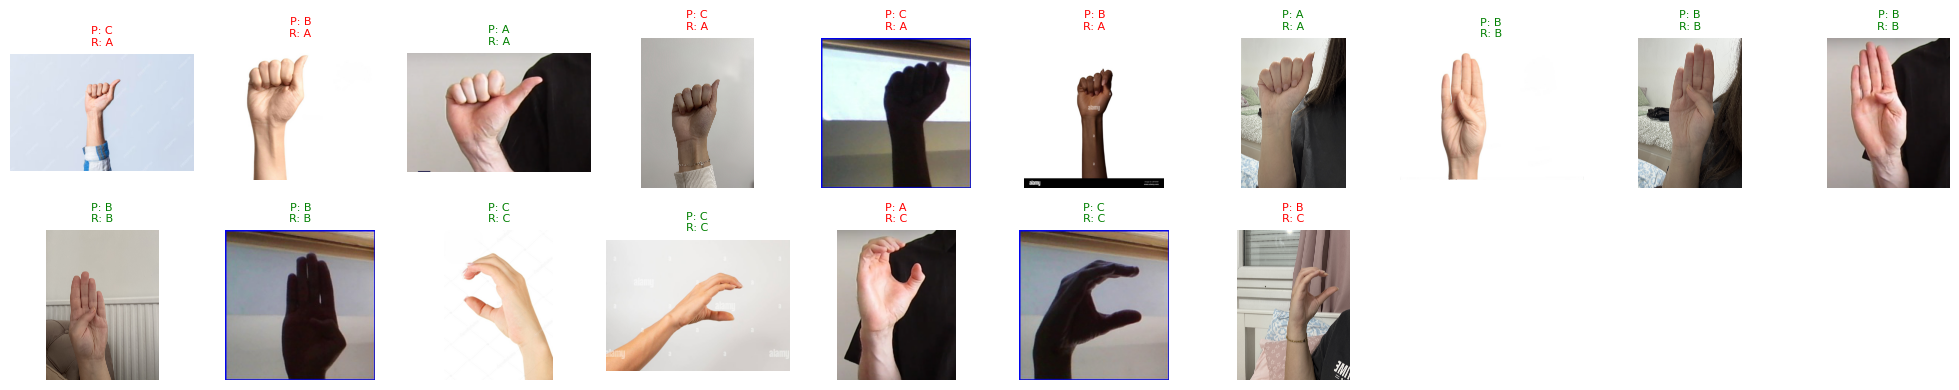

In [19]:
afficher_toutes_les_predictions(images_test, labels_test, model_ptr)

In [20]:
from collections import Counter
print("Train set :", Counter(labels_train))
print("Test set :", Counter(labels_test))


Train set : Counter({'A': 1276, 'B': 1214, 'C': 1205})
Test set : Counter({'A': 7, 'B': 5, 'C': 5})


In [22]:
y_preds = [lib.predict_deep_mlp_classifier(model_ptr, x.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), n_features)
           for x in X_test]

print("Prédictions:", y_preds)
print("Labels vrais:", Y_test.tolist())


Prédictions: [2, 1, 0, 0, 2, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2]
Labels vrais: [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0]]
